In [1]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix


Using TensorFlow backend.


In [2]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [3]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [4]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    reactor_list.append(join)

In [5]:
reactor_list[3]

,SVI,Temperature,F_M - B,Sludge Age - B
date,,,,
2010-01-01,87.904360,22.030,0.20,2.93
2010-01-02,106.039326,21.985,0.20,2.93
2010-01-03,83.333333,21.740,0.20,2.93
2010-01-04,102.176966,21.815,0.20,2.93
2010-01-05,106.995885,21.890,0.21,2.89
...,...,...,...,...
2020-09-11,154.702970,31.495,0.23,3.86
2020-09-12,158.013544,31.260,0.23,3.86
2020-09-13,155.502392,31.115,0.23,3.86


In [6]:
X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=2, binary=True)

In [7]:
X.shape

(15636, 2, 4)

In [8]:
Y

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [40]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.9)])
model.fit(Xtrain, ytrain, epochs=30, batch_size=10, shuffle=True)


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 364.15it/s]


Epoch 1/30
14072/14072 [==============================] - 3s 199us/step - loss: 0.2951 - binary_accuracy: 0.4363
Epoch 2/30
14072/14072 [==============================] - 2s 159us/step - loss: 0.2368 - binary_accuracy: 0.6613
Epoch 3/30
14072/14072 [==============================] - 2s 150us/step - loss: 0.2317 - binary_accuracy: 0.7115
Epoch 4/30
14072/14072 [==============================] - 2s 157us/step - loss: 0.2290 - binary_accuracy: 0.7336
Epoch 5/30
14072/14072 [==============================] - 2s 150us/step - loss: 0.2256 - binary_accuracy: 0.7462
Epoch 6/30
14072/14072 [==============================] - 2s 160us/step - loss: 0.2253 - binary_accuracy: 0.7549
Epoch 7/30
14072/14072 [==============================] - 2s 150us/step - loss: 0.2230 - binary_accuracy: 0.7605
Epoch 8/30
14072/14072 [==============================] - 2s 151us/step - loss: 0.2238 - binary_accuracy: 0.7653
Epoch 9/30
14072/14072 [==============================] - 2s 158us/step - loss: 0.2222 - binary_

In [41]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)

In [147]:
threshold = 0.7
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
y_real = Ytest.astype(int)

In [148]:
classes = ['High_svi', 'Low_svi']

In [149]:
cm = confusion_matrix(y_real, y_predict)

Confusion matrix, without normalization
[[ 115   60]
 [ 104 1285]]


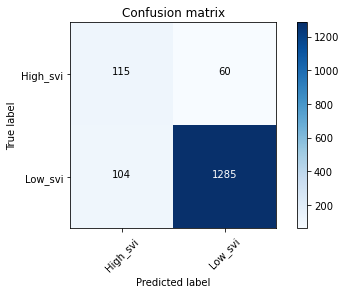

In [150]:
sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [151]:
results = km.results(y_real, y_predict, binary=True)

In [152]:
results

(0.8951406649616368,
 0.6571428571428571,
 0.5251141552511416,
 0.5837563451776651)

In [130]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [74]:
auc(fpr, tpr)

0.9064362850971922

Text(0.5, 1.0, 'ROC curve')

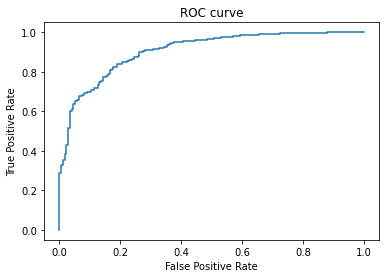

In [78]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [ ]:
results_list = []
for i in range (1,11):
    for j in range (1, 11):
        X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
        X_normalize, Y_normalize, scalers = km.normalize(X, Y)
        Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
        model.fit(Xtrain, ytrain, epochs=30, batch_size=10, shuffle=True)
        Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
        y_predict = np.rint(Yhat).astype(int)
        y_real = Ytest.astype(int)
        results_list.append(km.results(y_real, y_predict))
    


In [28]:
(unique, counts) = np.unique(ytrain, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [29]:
frequencies

array([[0.0000e+00, 1.7250e+03],
       [1.0000e+00, 1.2347e+04]])

In [ ]:
#plot graph of a metric result for all n_step_in and n_step_out values
x=range(1,11)
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(4):
    for i in range(10):
        y=[]
        for j in range (10):
            y.append(results_list[i*10:i*10+10][j][z+1])
        plt.plot(x, y, label=f'n_steps_in={i+1}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel(label[z])
    plt.title("Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
    plt.savefig(f"figures/Simple LSTM {label[z]}.png", bbox_inches="tight")
    plt.close()

In [ ]:
#plot graph of all metric results for a n_step_in value
x=range(1,11)
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(10):
    for i in range(4):
        y=[]
        for j in range (10):
            y.append(results_list[z*10:z*10+10][j][i+1])
        plt.plot(x, y, label=label[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel('Metric value')
    plt.title(f"Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+1} ")
    plt.savefig(f"figures/Simple LSTM n_steps_in={z+1}.png", bbox_inches="tight")
    plt.close()